## <font size=5> <strong> Groupe 4 - EI-2 DATA WEB - P\&G  </strong> </font>

Hector Bonnefoi - Sixtine Guerrand - Clément Lavenu - Antoine Pagneux - Maxime Zennaro

## I. Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import os
print(os.listdir())

path="data/"

['.DS_Store', '.git', '.vscode', '._.DS_Store', '._binary-classification.ipynb', '._test.csv', 'binary-classification-with-sklearn-and-keras-95.ipynb', 'binary-classification.ipynb', 'binary-classification_2.ipynb', 'binary-classification_vAntoine.ipynb', 'data', 'Documents', 'EI2-test.ipynb', 'load_datasets.py', 'README.md', 'test', 'test.csv']


## II. Importation et compréhension des jeux de données

In [3]:

def importation(filename):
    """ 
    Cette fontion permet d'importer et lire les différents fichiers .csv contenant les datasets
    :input: csv_file
        un dataset fourni
    :output: dataframe
        une représentation en tableau (dataframe) du dataset
    """
    return pd.read_csv(path+filename, sep=",")

#dataframe de soumission
sub_sample = importation("DS_Centrale_submission_sample.csv")

#dataframe de "actions des consommateurs"
cons_actions = importation("DS_CentraleSupelec_consumeractions.csv")

#dataframe des données à tester
test = importation("DS_CentraleSupelec_test.csv").fillna(0)

#dataframe des données d'entrainement
train = importation("DS_CentraleSupelec_train.csv").fillna(0)

#dataframe sur la dureté de l'eau en fonction du département (échelle : 1: eau douce,...,4:eau très dure)
df_dure = pd.read_csv(path+"eauxdures.csv",sep=";")

df_dure.head()

#train.head()

,Département,Dureté
0,1,3
1,2,3
2,3,1
3,4,3
4,5,3


In [4]:
def score_event(event):
    """
    Cette fonction permet de mettre un score sur les différents types 
    d'évenement que l'on peut retrouver dans le dataset 'consumeractions'
    :input: str
        un évenement (email open, email clicked...)
    :output: int
        un score compris entre 1 et 7 associé à l'évenement
    """
    s=0
    tokens=event.split()
    if "Email" in tokens:
        if "Opened" in tokens:
            s=1
        #email clicked
        else:
            s=2
    if "Product" in tokens: #Product Reviewed
        s=3
    if "Search" in tokens: #Search site
        s=4
    if "Coupon" in tokens:
        if "Request" in tokens:
            if "Print" in tokens:
                s=6
            #Request Coupon Add-to-basket
            else:
                s=5
        else:
            s=7
    return s

In [6]:
def postal_code_rank(df):
    """
    Cette fonction permet de regrouper les villes d'un même département (via leur code posta)
    et classer ensuite les départements en fonction de leur fréquence d'appairtion dans les datasets
    :input: dataframe
        le dataframe avec la colonne 'postalCode'
    :output: list
        une liste avec les départements classés et leur fréquence associée (liste de tuples)
    """
    dic_CP={}
            
    for j in range(len(df)):
        cp=df.iloc[j]['postalCode']
        if cp=="Nimes":
            dep=30
        else:
            dep=int(str(cp)[:2])
            
        if dep in dic_CP:
            dic_CP[dep]+=1
        else:
            dic_CP[dep]=0
    L_rank=sorted(dic_CP.items(), key=lambda x: x[1])   
    return L_rank

In [7]:
#mots clés associés au lave-vaisselle
key_words=['Fairy','PEPS','Platinum+']

In [8]:
# N.B : Cette fonction peut prendre 5 minutes pour calculer du fait du croisement avec le dataset 'consumeractions' 
# qui fait près de 1 millions de lignes pour les événements 

def clean_df_to_num(df_train,df_cons_act,data_type):
    """
    Cette fonction permet de générer un dataframe avec des données numériques 
    en appliqaunt différentes métriques pour chaque feature
    :input: dataframe, dataframe, str
        nous avons comme entrées, le dataframe à transformer numériquemement, le dataset 'consumeractions' 
        et savoir il s'agit de données d'entrainement ou de tests. Cette dernière options sert à juste nous dire 
        si on doit laisser la colonne 'washDishes' ou pas (dans le cas du dataset de test on l'enlève)
    :output: dataframe
        un score compris entre 1 et 7 associé à l'évenement
    """

    df_num=df_train[['age']]

    filters=['languageCode','countryCode','lastActivityDate','closestShop','registrationDate','detergentType']

    feature_names=df_train.keys()[1:]
    # print(feature_names)
    for col in feature_names:
        if str(col) not in filters:
            df_num[col]=0
    for coll in ['liquidDetergent','podsDetergent','powderDetergent','pc_score']:
        df_num[coll]=0
    
    #création de moyenne d'âge
    for i in range(len(df_train)):
        value=df_train.iloc[i]['age']
        if 10<=value<20:
            value=15
        if 20<=value<30:
            value=25
        if 30<=value<40:
            value=35
        if 40<=value<50:
            value=45
        if 50<=value<60:
            value=55
        if 60<=value<70:
            value=65
        if 70<=value<80:
            value=75
        if 80<=value<=90:
            value=85
        df_num.at[i,'age']=value
    
    df_num['score_event']=0
    
    #on garde la variable explicative pour l'entrainement
    if data_type=="training":
        df_num.loc[df_train.washDishes=="Auto",'washDishes']=1

    #on affecte nos métriques (binaire, échelle d'intensité de 1 à 4 ...)
    
    df_num.loc[df_train.gender=="F",'gender']=1
    df_num.loc[df_train.gender=="M",'gender']=0


    df_num.loc[df_train.ecoInterest=="Low",'ecoInterest']=1
    df_num.loc[df_train.ecoInterest=="Medium",'ecoInterest']=2
    df_num.loc[df_train.ecoInterest=="High",'ecoInterest']=3
    df_num.loc[df_train.ecoInterest=="Very high",'ecoInterest']=4


    df_num.loc[df_train.petOwner=="Yes",'petOwner']=1


    df_num.loc[df_train.MrPropreTrier=="Known Trier",'MrPropreTrier']=1
    df_num.loc[df_train.AntikalTrier=="Known Trier",'AntikalTrier']=1
    df_num.loc[df_train.ArielTrier=="Known Trier",'ArielTrier']=1
    df_num.loc[train.DashTrier=="Known Trier",'DashTrier']=1


    df_num.loc[df_train.toothBrushType=="Manual",'toothBrushType']=0
    df_num.loc[df_train.toothBrushType=="Electric",'toothBrushType']=1


    df_num.loc[df_train.emailContactable==True,'emailContactable']=1
    df_num.loc[df_train.postalContactable==True,'postalContactable']=1


    for i in range(17):
        
        if i < 5:
            df_num.loc[df_train.numberChildren==str(i),'numberChildren']=i

        else:
            df_num.loc[df_train.numberChildren==str(i),'numberChildren']=5

            
    df_num.loc[df_train.numberChildren=="4+",'numberChildren']=5
    df_num['numberChildren'] = pd.to_numeric(df_num['numberChildren'])

    
    df_num.loc[df_train.reactivationValue=="Lapsed",'reactivationValue']=3
    df_num.loc[df_train.reactivationValue=="Lapsing",'reactivationValue']=2
    df_num.loc[df_train.reactivationValue=="Dormant",'reactivationValue']=1
    df_num.loc[df_train.reactivationValue=="Active",'reactivationValue']=4


    df_num.loc[df_train.scentLover=="NonUser",'scentLover']=0
    df_num.loc[df_train.scentLover=="Low",'scentLover']=1
    df_num.loc[df_train.scentLover=="Medium",'scentLover']=2
    df_num.loc[df_train.scentLover=="High",'scentLover']=3



    for j in range(len(df_train)):
        cp=str(df_train.iloc[j]['postalCode'])
        
        # cas ou trouve le nom d'une ville dans code postal
        if cp=="Nimes":
            dep=30
        else:
            #département à un chiffre
            if len(cp)==4:
                dep=int(str(cp)[0])
            else:
                dep=int(str(cp)[:2])
            
            
        df_num.at[j,'postalCode']=dep
     
    # création de la colonne de la dureté de l'eau (new feature) en fonction du département
    for i in range(len(df_num)):
        
        dep=str(df_num["postalCode"][i])

        try:
            df_num['pc_score'][i]=df_dure[df_dure['Département']==dep].iloc[0]['Dureté']
        except:
            df_num['pc_score'][i]=0
    
    #on crée 3 colonnes différentes pour chaque type de détergents et on applique une métrique binaire
    for i in range(len(df_train)):
        value=df_train.iloc[i]['detergentType']
        if value!=0:
            value1=value.split(',')

            val_pods=0
            val_liq=0
            val_powd=0

            if 'Pods' in value1:
                val_pods=1
            if 'Liquid' in value1:
                val_liq=1
            if 'Powder' in value1:
                val_powd=1
                
            df_num.at[i,'liquidDetergent']=val_liq
            df_num.at[i,'podsDetergent']=val_pods
            df_num.at[i,'powderDetergent']=val_powd
            
            
    ## on rajoute une feature du dataset 'consumeractions'
    
    liste_userID=df_train['userId'].unique()
    dic_events={}
    
    for userId in liste_userID:
        dic_events[userId]=0
        
    df=df_cons_act    
    
    # on regarde si nous avons des mots clés sur les laves-vaisselles (les key-words plus haut) ject line'
    # et on regarde les évènements associés puis on attribut un score global par utilisateur
    for i in range(len(df)): 
        bd=df.iloc[i]['brandName']
        subject=df.iloc[i]['subjectLine']
        
        status=False
        try:
            if any(word in bd.split() for word in key_words) :
                status=True
        except:
            None
        try:
            if any(word in subject.split() for word in key_words):
                status=True
        except:
            None
        if status==True:
            try:
                dic_events[df.iloc[i]['userId']] += score_event(df.iloc[i]['event'])      
                
            except:
                None
         
    for i in range(len(df_num)):
        
        keyID=df_train.iloc[i]['userId']
        if keyID in dic_events:
            df_num.at[i,'score_event']=dic_events[keyID]
    
    return df_num


In [9]:
#dataframe numérique sur les données d'entrainement
df_num=clean_df_to_num(train,cons_actions,"training")
df_num.head()

<ipython-input-8-dc692bde57e3>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col]=0
<ipython-input-8-dc692bde57e3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[coll]=0
<ipython-input-8-dc692bde57e3>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

,age,gender,emailContactable,postalContactable,postalCode,numberChildren,reactivationValue,toothBrushType,MrPropreTrier,AntikalTrier,...,DashTrier,scentLover,petOwner,ecoInterest,washDishes,liquidDetergent,podsDetergent,powderDetergent,pc_score,score_event
0,25,1,1,1,68,1,2,0,0,0,...,0,0,1,0,1,1,0,0,2,0
1,65,1,1,1,17,3,4,0,1,1,...,0,0,0,3,1,0,1,0,3,1
2,45,1,1,1,30,1,4,0,0,0,...,1,0,1,3,1,1,0,0,3,0
3,35,1,1,1,61,2,4,0,0,0,...,1,1,1,2,0,0,1,0,3,0
4,35,1,1,1,30,0,4,1,1,1,...,1,0,1,1,0,1,0,0,3,0


#### Taille du dataset

In [10]:
df_num.shape

(12000, 21)

#### Affichage de certaines lignes

In [11]:
df_num.sample(5)

,age,gender,emailContactable,postalContactable,postalCode,numberChildren,reactivationValue,toothBrushType,MrPropreTrier,AntikalTrier,...,DashTrier,scentLover,petOwner,ecoInterest,washDishes,liquidDetergent,podsDetergent,powderDetergent,pc_score,score_event
8738,35,1,1,1,31,2,1,0,0,0,...,0,1,1,0,0,1,0,0,2,0
5242,45,1,1,1,69,0,4,0,0,0,...,1,0,1,1,1,0,0,0,2,5
10898,35,1,1,1,29,0,4,0,0,0,...,0,0,1,0,0,1,0,0,1,5
11516,75,1,1,1,45,0,4,0,0,0,...,1,0,0,0,0,0,1,0,3,2
5712,35,1,1,1,83,5,4,1,0,0,...,0,1,1,3,0,0,0,0,3,0


#### Description

In [43]:
df_num.describe()

,age,gender,emailContactable,postalContactable,postalCode,numberChildren,reactivationValue,toothBrushType,MrPropreTrier,AntikalTrier,...,DashTrier,scentLover,petOwner,ecoInterest,washDishes,liquidDetergent,podsDetergent,powderDetergent,pc_score,score_event
count,12000.000000,12000.000000,12000.000000,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,40.678417,0.866083,0.880167,0.89400,51.768583,1.275583,3.369667,0.340333,0.171000,0.066000,...,0.344500,0.529750,0.600417,1.370083,0.382000,0.500583,0.348083,0.037750,2.581667,0.682833
std,14.446351,0.340577,0.324780,0.30785,26.970517,1.294454,1.057090,0.473841,0.376525,0.248292,...,0.475225,0.912607,0.489833,1.314065,0.485897,0.500020,0.476382,0.190599,1.075683,1.905748
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,1.000000,1.000000,1.00000,31.000000,0.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,35.000000,1.000000,1.000000,1.00000,58.000000,1.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000
75%,45.000000,1.000000,1.000000,1.00000,74.000000,2.000000,4.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000
max,95.000000,1.000000,1.000000,1.00000,98.000000,5.000000,4.000000,1.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,47.000000


In [12]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                12000 non-null  int64
 1   gender             12000 non-null  int64
 2   emailContactable   12000 non-null  int64
 3   postalContactable  12000 non-null  int64
 4   postalCode         12000 non-null  int64
 5   numberChildren     12000 non-null  int64
 6   reactivationValue  12000 non-null  int64
 7   toothBrushType     12000 non-null  int64
 8   MrPropreTrier      12000 non-null  int64
 9   AntikalTrier       12000 non-null  int64
 10  ArielTrier         12000 non-null  int64
 11  DashTrier          12000 non-null  int64
 12  scentLover         12000 non-null  int64
 13  petOwner           12000 non-null  int64
 14  ecoInterest        12000 non-null  int64
 15  washDishes         12000 non-null  int64
 16  liquidDetergent    12000 non-null  int64
 17  podsDetergen

#### Analyse de la variable à expliquer

In [13]:
df_num["washDishes"].describe()

count    12000.000000
mean         0.382000
std          0.485897
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: washDishes, dtype: float64

In [14]:
df_num["washDishes"].unique()

array([1, 0], dtype=int64)

### Corrélation des features

In [15]:
print(df_num.corr()["washDishes"].abs().sort_values(ascending=False))

washDishes           1.000000
numberChildren       0.154992
age                  0.153612
toothBrushType       0.111456
ecoInterest          0.109189
score_event          0.099711
petOwner             0.097935
reactivationValue    0.092396
postalContactable    0.082962
emailContactable     0.073574
podsDetergent        0.048025
gender               0.047276
scentLover           0.038834
ArielTrier           0.034418
AntikalTrier         0.026565
DashTrier            0.021948
postalCode           0.020273
MrPropreTrier        0.017828
pc_score             0.014453
liquidDetergent      0.008464
powderDetergent      0.004458
Name: washDishes, dtype: float64


## Analyse des données

### Analyse de la variable 'washDishes'

0    7416
1    4584
Name: washDishes, dtype: int64
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


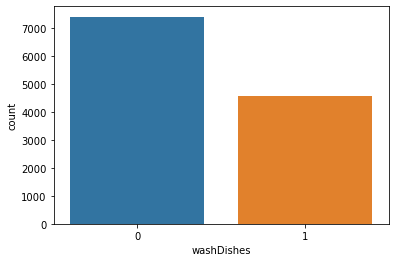

In [48]:
y = df_num["washDishes"]

sns.countplot(y)

target_temp = df_num.washDishes.value_counts()

print(target_temp)

In [49]:
print("Pourcentage de personnes lavant sa vaisselle à la main"+str(round(target_temp[0]*100/12000,2)))
print("Pourcentage de personnes ayant un lave-vaisselle "+str(round(target_temp[1]*100/12000,2)))


Pourcentage de personnes lavant sa vaisselle à la main61.8
Pourcentage de personnes ayant un lave-vaisselle 38.2


### Analyse de la feature 'âge'

In [50]:
df_num["age"].unique()

array([25, 65, 45, 35, 55, 75,  0, 85, 15, 95, 91, 93, 94])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='washDishes'>

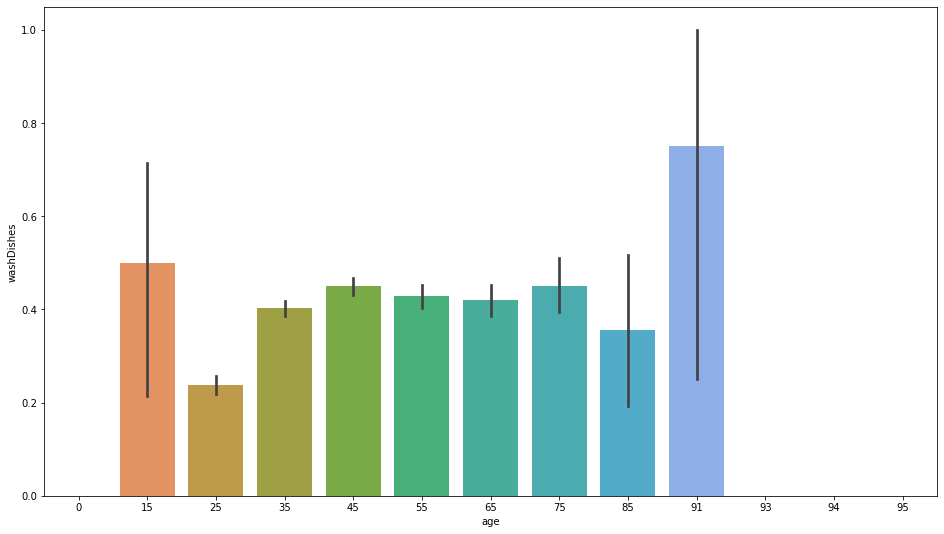

In [51]:
plt.figure(figsize=(16,9))
sns.barplot(df_num["age"],y)

### Analyse de la feature 'ecoInterest'

In [52]:
df_num["ecoInterest"].unique()

array([0, 3, 2, 1, 4])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ecoInterest', ylabel='washDishes'>

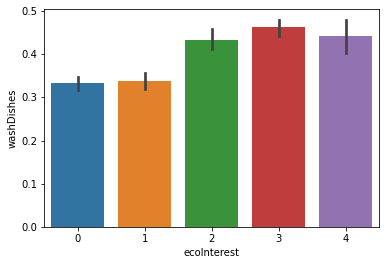

In [53]:
sns.barplot(df_num["ecoInterest"],y)

##### We notice, that chest pain of '0', i.e. the ones with typical angina are much less likely to have heart problems

### Analyse de la feature 'gender'

In [54]:
df_num["gender"].unique()

array([1, 0])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='washDishes'>

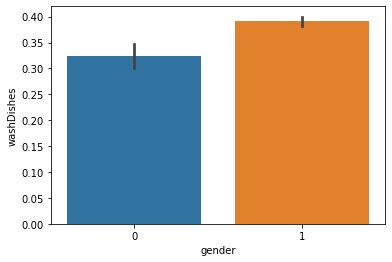

In [55]:
sns.barplot(df_num["gender"],y)

### Analyse de la feature 'toothBrushType'

In [56]:
df_num["toothBrushType"].unique()

array([0, 1])

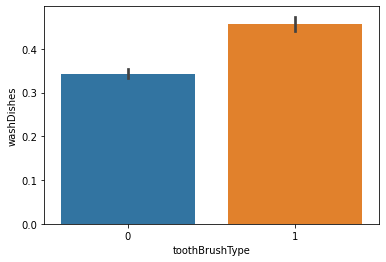

In [62]:
sns.barplot(df_num["toothBrushType"],y)

### Analyse de la feature 'reactivationValue'

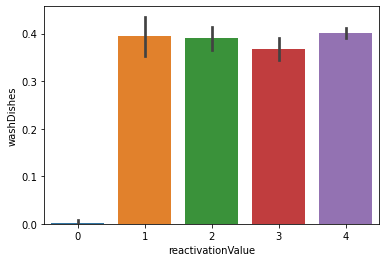

In [63]:
df_num["reactivationValue"].unique()
sns.barplot(df_num["reactivationValue"],y)

### Analyse de la feature 'postalCode' avec département uniquement

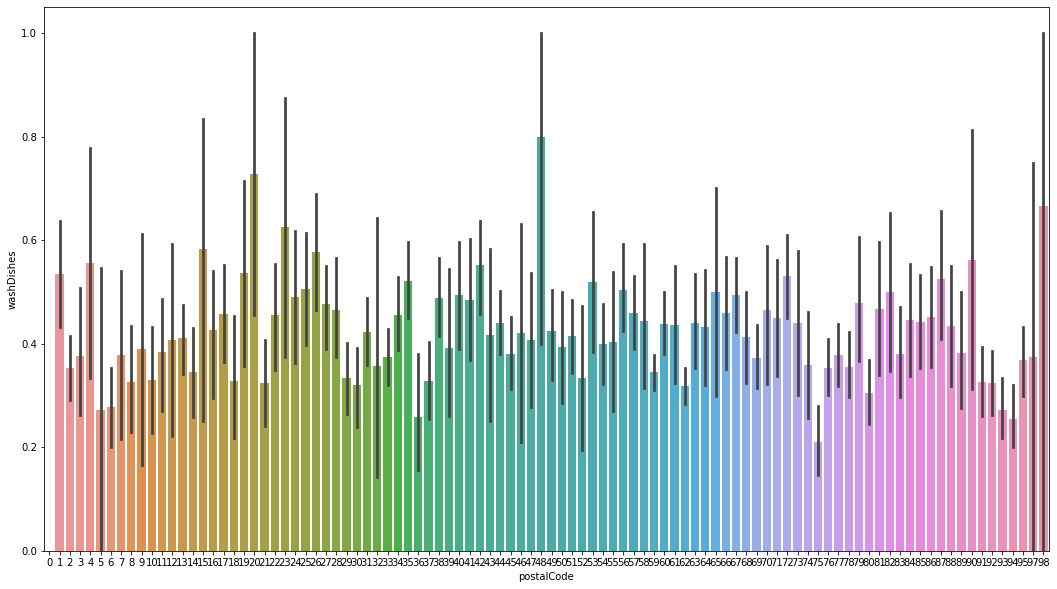

In [73]:
df_num["postalCode"].unique()
plt.figure(figsize=(18,10))
sns.barplot(df_num["postalCode"],y)

## IV. Phase d'apprentissage

In [16]:
from sklearn.model_selection import train_test_split

#filtres = features non utilisés
filters=['scentLover','ArielTrier' ,'AntikalTrier','DashTrier' ,'MrPropreTrier','postalCode','liquidDetergent','powderDetergent']

#filters=['detergentType','scentLover','ArielTrier' ,'AntikalTrier', 'DashTrier' ,'MrPropreTrier','detergentType','petOwner','reactivationValue', 'postalContactable','emailContactable', 'postalCode']

# données d'entrainements
predictors = df_num.drop(filters+['washDishes'],axis=1)
target = df_num["washDishes"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

# dataset de tests (qui sera à soumettre)
df_test=clean_df_to_num(test,cons_actions,"test").drop(filters,axis=1)
df_test.head()


<ipython-input-8-dc692bde57e3>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col]=0
<ipython-input-8-dc692bde57e3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[coll]=0
<ipython-input-8-dc692bde57e3>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

,age,gender,emailContactable,postalContactable,numberChildren,reactivationValue,toothBrushType,petOwner,ecoInterest,podsDetergent,pc_score,score_event
0,35,1,1,1,5,4,0,0,3,0,4,0
1,45,1,1,1,2,2,0,1,3,0,2,0
2,25,1,0,1,1,4,0,1,0,0,4,0
3,65,1,1,1,3,4,0,0,0,0,2,4
4,45,1,1,1,2,4,0,1,2,1,2,7


In [17]:
X_train.shape

(9600, 12)

In [18]:
X_test.shape

(2400, 12)

In [19]:
Y_train.shape

(9600,)

In [20]:
Y_test.shape

(2400,)

In [21]:
def generate_csv_submission(filename, Y):
    """
    Cette fonction permet de générer un fichier csv contenant les résultats obtenus 
    afin de les soumettre sur Kaggle au bon format
    :input: file, array
        fichier sur lequel écrire, listes des résultats prédits (Y)
    :output: None
        création du fichier résultat dans le répertoire "data"
    """
    file = open(filename + ".csv", 'w')
    with open("data/DS_Centrale_submission_sample.csv", 'r') as filin:
        i = 0
        line = filin.readline()
        file.write(line)
        while line != "" and i < len(Y):
            line = filin.readline()
            line_splited = line.split(",")
            if Y[i] == 0:
                line_splited[1] = 'Hand\n'
            new_line = line_splited[0] + "," + line_splited[1]
            file.write(new_line) 
            i += 1
        file.close()       




## V. Modèle statistiques utilisés

In [22]:
from sklearn.metrics import accuracy_score,confusion_matrix
import collections

On utilise d'abord quelques modèles de classification et on en choisira quelques un (les plus prometteurs...) en essayant d'optimiser les différents hyperparamètres.

### Logistic Regression

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={
    "C" : np.logspace(-3, 3, 7),
     "penalty" : ["l1","l2"],
     }
logreg=LogisticRegression(solver='saga')
logreg_cv=GridSearchCV(logreg, grid, cv=10)
logreg_cv.fit(X_train,Y_train)

print(logreg_cv.best_params_)

n("The max_iter was reached which means "
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: Con

In [40]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='saga', max_iter=1000)
lr.fit(X_train,Y_train)
Y_pred_lr = lr.predict(X_test)

In [41]:
score_lr = round(accuracy_score(Y_pred_lr,Y_test)*100,2)
print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")
conf = confusion_matrix(Y_test,Y_pred_lr )
conf

The accuracy score achieved using Logistic Regression is: 64.88 %


array([[1319,  184],
       [ 659,  238]], dtype=int64)

In [42]:
df_test.shape
Y_real_lr = lr.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ",collections.Counter(Y_real_lr))


Nombre de manuels (0) et d'automatiques (1) :  Counter({0: 3280, 1: 720})


In [41]:
# génération du fichier csv
#generate_csv_submission("data/test_lr", Y_real_lr)

### Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,Y_train)

Y_pred_nb = nb.predict(X_test)
Y_pred_nb.shape

(2400,)

In [29]:
score_nb = round(accuracy_score(Y_pred_nb,Y_test)*100,2)
print("The accuracy score achieved using Logistic Regression is: "+str(score_nb)+" %")
conf = confusion_matrix(Y_test,Y_pred_nb )
conf

The accuracy score achieved using Logistic Regression is: 61.54 %


array([[1062,  441],
       [ 482,  415]], dtype=int64)

In [30]:
df_test.shape
Y_real_nb = nb.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ",collections.Counter(Y_real_nb))


Nombre de manuels (0) et d'automatiques (1) :  Counter({0: 2486, 1: 1514})


In [48]:
# Génération du fichier csv
#generate_csv_submission("data/test_nb", Y_real_nb)

### SVM

In [48]:
from sklearn import svm

sv = svm.SVC(kernel='rbf')
sv.fit(X_train, Y_train)
Y_pred_svm = sv.predict(X_test)

In [49]:
Y_pred_svm.shape

(2400,)

In [50]:
score_svm = round(accuracy_score(Y_pred_svm,Y_test)*100,2)
print("The accuracy score achieved using Linear SVM is: "+str(score_svm)+" %")

The accuracy score achieved using Linear SVM is: 63.0 %


In [51]:
df_test.shape
Y_real_svm = sv.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ", collections.Counter(Y_real_svm))

Nombre de manuels (0) et d'automatiques (1) :  Counter({0: 3954, 1: 46})


### K Nearest Neighbors

In [81]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,Y_train)
Y_pred_knn=knn.predict(X_test)

In [82]:
Y_pred_knn.shape

(2400,)

In [83]:
score_knn = round(accuracy_score(Y_pred_knn,Y_test)*100,2)

print("The accuracy score achieved using KNN is: "+str(score_knn)+" %")

The accuracy score achieved using KNN is: 59.54 %


### Random Forest 
(Avec optimisation des hyperparamètres)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [134]:
# Optimisation des hyperparamètres à l'aide de l'outil GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, 100, 110],
    'max_features': [2, 3, 4, 5, 6],
    'min_samples_leaf': [10, 20, 30, 40],
    'min_samples_split': [6, 8, 10, 12],
    'n_estimators': np.arange(80, 240, 20)
}# Create a based model

rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 3200 candidates, totalling 9600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 7930 tasks      

#### tests d'optimisation : 

* test1

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5, 8, 12 ],
    'min_samples_split': [10, 12, 14],
    'n_estimators': [10, 100, 200]
}# Create a based model

{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 200}

* test2

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [8, 12, 15, 20 ],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}# Create a based model

{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 20, 'min_samples_split': 8, 'n_estimators': 100}

rfc = RandomForestClassifier(n_estimators=100, min_samples_leaf = 20, min_samples_split = 8, max_features = 2, max_depth = 80)

Accuracy: 0.6491666666666667
Mean Absolute Error: 0.35083333333333333
Mean Squared Error: 0.35083333333333333
Root Mean Squared Error: 0.5923118547972287


* test 3

param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, 100, 110],
    'max_features': [1, 2, 3, 4],
    'min_samples_leaf': [10, 15, 20, 25, 30],
    'min_samples_split': [6, 8, 10, 12],
    'n_estimators': [20, 50, 100, 200, 300]
}# Create a based model

{'bootstrap': True, 'max_depth': 90, 'max_features': 2, 'min_samples_leaf': 30, 'min_samples_split': 10, 'n_estimators': 200}

rfc = RandomForestClassifier(n_estimators=200, min_samples_leaf = 30, min_samples_split = 10, max_features = 2, max_depth = 90)

Accuracy: 0.6458333333333334
Mean Absolute Error: 0.3541666666666667
Mean Squared Error: 0.3541666666666667
Root Mean Squared Error: 0.5951190357119042

* test 4

param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, 100, 110],
    'max_features': [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [10, 20, 30, 40],
    'min_samples_split': [6, 8, 10, 12],
    'n_estimators': [20, 50, 100, 200, 300]
}# Create a based model

{'bootstrap': True, 'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 12, 'n_estimators': 180}

In [33]:
rfc = RandomForestClassifier(n_estimators=180, min_samples_leaf = 10, min_samples_split = 12, max_features = 4, max_depth = 90)
rfc.fit(X_train,Y_train)
y_pred_rfc =  rfc.predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_test, y_pred_rfc))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_rfc))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_rfc))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_rfc)))

Accuracy: 0.65625
Mean Absolute Error: 0.34375
Mean Squared Error: 0.34375
Root Mean Squared Error: 0.5863019699779287


In [34]:
# Calcul sur l'échantillon de test
Y_test_pred_rf = rfc.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ",collections.Counter(Y_test_pred_rf))

# Génération du fichier CSV
generate_csv_submission("data/randomforest_gridsearchcv_12feats_eaudures_2", Y_test_pred_rf)

Nombre de manuels (0) et d'automatiques (1) :  Counter({0: 3108, 1: 892})


### XGBoost
(Avec optimisation des hyperparamètres)

In [135]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [88]:
# Optimisation des hyperparamètres à l'aide de l'outil GridSearchCV

estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
)


parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'seed' : np.arange(30,50,2),
    'nthread' : np.arange(2,6,1)
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, Y_train)


print(grid_search.best_estimator_)
print(grid.best_params_)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


KeyboardInterrupt: 

* test1

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(100, 1000, 50),
    'learning_rate': [0.1, 0.01, 0.05]
}

{'colsample_bytree': 0.72, 'eta': 0.1, 'gamma': 5, 'min_child_weight': 4.0, 'subsample': 0.72}

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'nthread': 2, 'seed': 30}

In [130]:
xgb_model = xgb.XGBClassifier(objective= 'binary:logistic',
    nthread=2,
    seed=42,
    colsample_bytree = 0.72,
    eta = 0.1,
    gamma = 5,
    min_child_weight = 4.0,
    subsample = 0.72,
    max_depth = 3,
    n_estimator = 100,
    learning_rate = 0.05
)

xgb_model.fit(X_train, Y_train)

Y_pred_xgb = xgb_model.predict(X_test)
Y_pred_xgb.shape

[13:46:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(2400,)

In [132]:
score_xgb = round(accuracy_score(Y_pred_xgb,Y_test)*100,2)

print("The accuracy score achieved using XGBoost is: "+str(score_xgb)+" %")
print(collections.Counter(Y_pred_xgb))

Y_test_pred_xgb = xgb_model.predict(df_test)
print(confusion_matrix(Y_test, Y_pred_xgb))
print(collections.Counter(Y_test_pred_xgb))

# Génération des fichiers csv
generate_csv_submission("data/xgboost_12feats_xgboost_2", Y_test_pred_xgb)

The accuracy score achieved using XGBoost is: 65.58 %
Counter({0: 1913, 1: 487})
[[1295  208]
 [ 618  279]]
Counter({0: 3162, 1: 838})


### Neural Network

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [102]:
# Optimisation des hyperparamètres à l'aide de l'outil GridSearchCV

param_grid_mlpc = {
    'solver': ['lbfgs'], 
    'max_iter': [1000,2000,5000], 
    'hidden_layer_sizes' : np.arange(40, 50, 1), 
    'random_state':[0,1,2,3],
    'activation': ['logistic', 'tanh']
}


clf = MLPClassifier(alpha=1e-5)
grid_search_mlpc = GridSearchCV(estimator = clf, param_grid = param_grid_mlpc, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search_mlpc.fit(X_train, Y_train)

print(grid_search_mlpc.best_params_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 100.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 117.4min finished
{'activation': 'logistic', 'hidden_layer_sizes': 42, 'max_iter': 1000, 'random_state': 3, 'solver': 'lbfgs'}
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [37]:
# Optimisation de l'hyperparamètre lié au nombre de couches cachée à l'aide de l'outil GridSearchCV

hidden_layer_sizes_liste = []
for i in range(1,30):
    hidden_layer_sizes_liste.append((42,i))

print(hidden_layer_sizes_liste)

param_grid_mlpc_2 = {
    'hidden_layer_sizes' : hidden_layer_sizes_liste, 
}


clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(42,17), random_state=3, max_iter=1000, activation = 'logistic')
grid_search_mlpc = GridSearchCV(estimator = clf, param_grid = param_grid_mlpc_2, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search_mlpc.fit(X_train, Y_train)

print(grid_search_mlpc.best_params_)

[(42, 1), (42, 2), (42, 3), (42, 4), (42, 5), (42, 6), (42, 7), (42, 8), (42, 9), (42, 10), (42, 11), (42, 12), (42, 13), (42, 14), (42, 15), (42, 16), (42, 17), (42, 18), (42, 19), (42, 20), (42, 21), (42, 22), (42, 23), (42, 24), (42, 25), (42, 26), (42, 27), (42, 28), (42, 29)]
Fitting 3 folds for each of 29 candidates, totalling 87 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  8.1min finished
{'hidden_layer_sizes': (42, 24)}
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### tests d'optimisation : 
* test1

param_grid_mlpc = {
    'solver': ['lbfgs', 'sgd', 'adam'], 
    'max_iter': [100,1000,2000, 3000], 
    'hidden_layer_sizes' : np.arange(3, 9, 3), 
    'random_state':[0,1,2,5],
    'activation': ['logistic', 'tanh', 'relu']
}

{'activation': 'logistic', 'hidden_layer_sizes': 6, 'max_iter': 1000, 'random_state': 1, 'solver': 'lbfgs'}

* test2

param_grid_mlpc = {
    'solver': ['lbfgs'], 
    'max_iter': [1000, 3000, 5000], 
    'hidden_layer_sizes' : np.arange(3, 46, 3), 
    'random_state':[0,1,2,5,10],
    'activation': ['logistic', 'tanh', 'relu']
}

{'activation': 'tanh', 'hidden_layer_sizes': 45, 'max_iter': 1000, 'random_state': 2, 'solver': 'lbfgs'}

* test3

param_grid_mlpc = {
    'solver': ['lbfgs'], 
    'max_iter': [1000], 
    'hidden_layer_sizes' : np.arange(40, 50, 1), 
    'random_state':[0,1,2],
    'activation': ['logistic', 'tanh']
}
{'activation': 'tanh', 'hidden_layer_sizes': 45, 'max_iter': 1000, 'random_state': 2, 'solver': 'lbfgs'}

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(43,11), random_state=2, max_iter=1000, activation = 'tanh')

Counter({0: 1931, 1: 469})

0.6516666666666666
[[1299  204]
 [ 632  265]]

 * test4

 param_grid_mlpc = {
    'solver': ['lbfgs'], 
    'max_iter': [1000,2000,5000], 
    'hidden_layer_sizes' : np.arange(40, 50, 1), 
    'random_state':[0,1,2,3],
    'activation': ['logistic', 'tanh']
}

{'activation': 'logistic', 'hidden_layer_sizes': 42, 'max_iter': 1000, 'random_state': 3, 'solver': 'lbfgs'}

Counter({0: 1900, 1: 500})
0.6520833333333333
[[1284  219]
 [ 616  281]]

* test5

param_grid_mlpc_2 = {
    'hidden_layer_sizes' : hidden_layer_sizes_liste, 
}

{'hidden_layer_sizes': (42, 24)}


 

In [38]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(42,24), random_state=3, max_iter=1000, activation = 'logistic')

clf.fit(X_train, Y_train)

predictions = clf.predict(X_test)

print(collections.Counter(predictions))
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))

Counter({0: 1897, 1: 503})
0.65
[[1280  223]
 [ 617  280]]
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [39]:
# Calcul sur l'échantillon de test
Y_test_pred = clf.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ", collections.Counter(Y_test_pred))

# Génération du fichier csv
generate_csv_submission("data/res_neuronnes_12feats_qualite_eau_gridsearchcv_logitic_3", Y_test_pred)

Nombre de manuels (0) et d'automatiques (1) :  Counter({0: 3060, 1: 940})


## VI. Output final score

In [ ]:
s